## 学習用データの作成

In [1]:
import numpy as np
import pandas as pd
from IPython.display import Image
import category_encoders as ce

import graphviz
import lingam
from lingam.utils import make_dot, make_prior_knowledge
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

display(pd.DataFrame(df.isnull().sum()).T)

df = df.drop(["Cabin"], axis=1)
df = df.dropna(how='any')

display(pd.DataFrame(df.isnull().sum()).T)

display(df.head(3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,0,177,0,0,0,0,687,2


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,0,0,0,0,0,0,0,0,0,0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


In [3]:
oe = ce.ordinal.OrdinalEncoder(
    cols=df.select_dtypes(include="object")
    )

df_en = oe.fit_transform(df)

## LIGNAM

### 可読性のため特徴量とindex の辞書を作成

In [4]:
df_list = df_en.drop("PassengerId", axis=1).columns.to_list()
df_dict = {}

for i, column in zip(range(len(df_list)), df_list):
    df_dict[column] = i

print(len(df_list))
print(df_dict)

10
{'Survived': 0, 'Pclass': 1, 'Name': 2, 'Sex': 3, 'Age': 4, 'SibSp': 5, 'Parch': 6, 'Ticket': 7, 'Fare': 8, 'Embarked': 9}


### 事前知識の設定

In [5]:
prior_knowledge = make_prior_knowledge(
    10,                                          # 変数の数

    # 外因性変数? 1D-list 一覧
    exogenous_variables = [df_dict["Sex"], df_dict["Age"]],

    # シンク変数? 1D-list 一覧
    sink_variables = [df_dict["Survived"]],     

    # 有向パスを持つ変数 2D-list 組み合わせ
    paths = [
             [df_dict["Survived"], df_dict["Sex"]],
             ],     

    # 有向パスのない変数 2D-list 組み合わせ
    no_paths = [
                [df_dict["Survived"], df_dict["Embarked"]],
                 ],                           
)

### 統計的因果推論の学習

In [6]:
# インスタンスを生成して、.fitするだけで簡単に実行できる
model = lingam.DirectLiNGAM(
                    random_state=42,
                    measure = 'pwling', # kernel
                    prior_knowledge = prior_knowledge
                    )

model.fit(df_en.drop("PassengerId", axis=1))

### 因果グラフの表示

In [7]:
dot = make_dot(
    model.adjacency_matrix_,   # LiNGAMで推定された因果グラフを表す隣接行列。 (i,j)成分の中身の値はx_iからx_jへの因果係数b_ijを表す
     labels=df_en.drop("PassengerId", axis=1).columns.to_list(),
    )

# 画像を保存
dot.format = 'png'
dot.render('dag')

'dag.png'

## 学習モデルの特徴量の相関係数を追加

In [8]:
## ロジスティック回帰
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42)
clf.fit(df_en.drop(["PassengerId", "Survived"], axis=1), df_en["Survived"])

LogisticRegression(random_state=42)

features:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


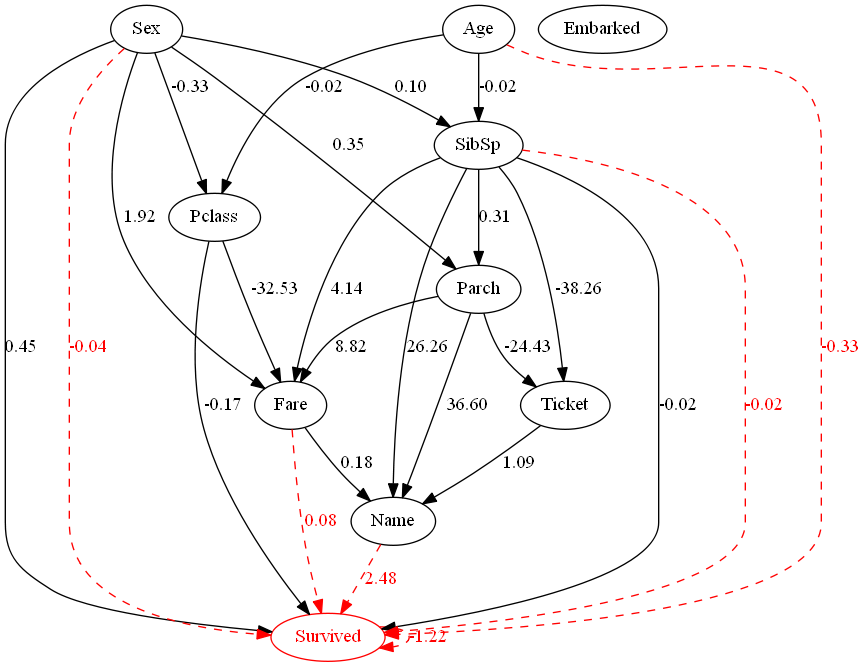

In [9]:
features = [i for i in range(df_en.drop(["PassengerId", "Survived"], axis=1).shape[1])]
print("features: ", features)

dot = make_dot(
    model.adjacency_matrix_,
    labels=df_en.drop("PassengerId", axis=1).columns.to_list(),
    prediction_feature_indices=features, 
    prediction_target_label='Survived',
    prediction_coefs=clf.coef_[0]
    )

# 画像を保存
dot.format = 'png'
dot.render('dag')

Image("dag.png")

## 学習モデルの特徴量の重要性を追加

In [10]:
## lightGBM
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
clf = lgb.LGBMClassifier(random_state=42)
clf.fit(df_en.drop(["PassengerId", "Survived"], axis=1), df_en["Survived"])

LGBMClassifier(random_state=42)

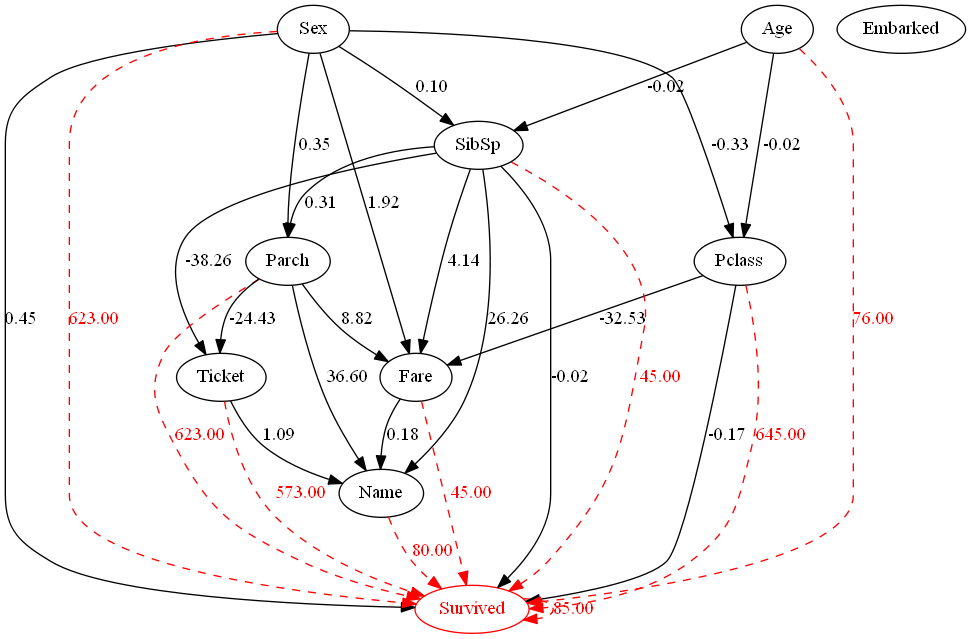

In [11]:
dot = make_dot(
    model.adjacency_matrix_,
    labels=df_en.drop("PassengerId", axis=1).columns.to_list(),
    prediction_feature_indices=features, 
    prediction_target_label='Survived',
    prediction_coefs=clf.feature_importances_
    )

# 画像を保存
dot.format = 'png'
dot.render('dag')

Image("dag.png")

## 予測に最大の因果的影響を与えた特徴量の推定

In [12]:
lce = lingam.CausalEffect(model)
effects = lce.estimate_effects_on_prediction(
                                    df_en.drop(["PassengerId"], axis=1),
                                    df.columns.to_list().index("Survived"), # 目的変数 Survived の index を指定
                                    clf
                                    )


df_effects = pd.DataFrame()
df_effects['feature'] = df_en.drop(["PassengerId"], axis=1).columns
df_effects['effect_plus'] = effects[:, 0]
df_effects['effect_minus'] = effects[:, 1]*-1
display(df_effects)

# 予測に最大の因果的影響を与えた特徴量
max_index = np.unravel_index(np.argmax(effects), effects.shape)
print(df_en.drop(["PassengerId"], axis=1).columns[max_index[0]])

,feature,effect_plus,effect_minus
0,Survived,0.000000,-0.000000
1,Pclass,0.179644,-1.351305
2,Name,0.068728,-0.086426
3,Sex,1.601848,-0.707095
4,Age,0.103066,-0.268804
5,SibSp,0.173081,-0.167627
6,Parch,0.126403,-0.362837
7,Ticket,0.447921,-0.029969
8,Fare,0.989454,-0.212332
9,Embarked,0.148050,-0.000000


Sex


## 指定した特徴量の影響度(推定)

In [13]:
column_x = "SibSp"
column_y = "Pclass"

te = model.estimate_total_effect(df_en.drop(["PassengerId"], axis=1), df_dict[column_x], df_dict[column_y])
print(f'{df_dict[column_x]}:{column_x}から{df_dict[column_y]}:{column_y}までの 影響度 合計: {te:.3f}')

5:SibSpから1:Pclassまでの 影響度 合計: 0.000
